# Data Exploration


## Import packages

In [54]:
import pandas as pd
import requests 
import cv2
import matplotlib.pyplot as plt
import numpy as np


## Read csv file

In [68]:
data = pd.read_csv('Data/data.csv', index_col=0)
data.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


We are only focus on the images, so the Photo column is the one that contains the urls that we need to download.
Let's create a simple function that can download one image from a url and saves it to a given file

In [69]:
def download_image_from_url(url, filename):
    response = requests.get(url)
    
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)

In [149]:
filename = 'Data/Messi.png'
download_image_from_url('https://cdn.sofifa.org/players/4/19/158023.png', filename)

## Visualization

We were able to download an image from the url, let's have a look at it now!

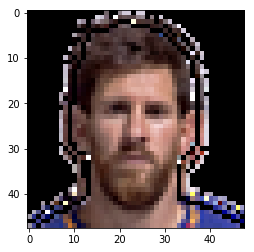

In [181]:
img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)

# We need to convert the image to RGB before plotting since OPENCV uses BGR format
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

We observe some problems here... It seems the image was processed with some smoothing technique between player and the background. If we observe each channel separately we can see this fact clearly.

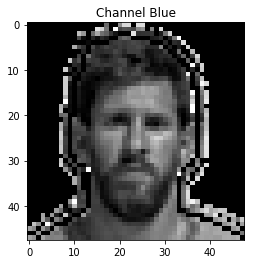

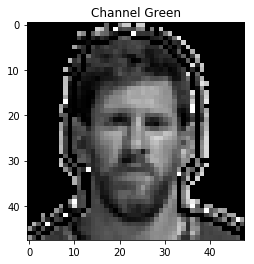

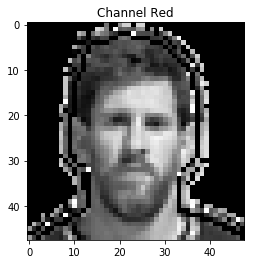

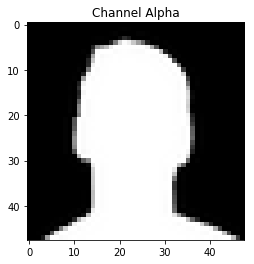

In [167]:
channels = ['Blue', 'Green', 'Red', 'Alpha']
for i, c in zip(range(img.shape[2]), channels):
    plt.imshow(img[...,i], cmap='gray')
    plt.title('Channel ' + c)
    plt.show()

It seems the alpha channel (the last one) fits the original face of the player. We must note that pixel intensities of this channel are not binary. We can easily appreciate different shades of gray in there.

Let's binarize this image and see if we can get a good mask of the player face.


Text(0.5, 1.0, 'Channel Alpha Thresholded')

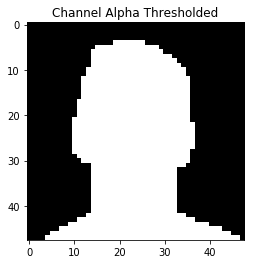

In [195]:
binary = (img[:,:,3]>50)
plt.imshow(binary, cmap='gray')
plt.title('Channel Alpha Thresholded')

If we use this binary image as a mask (this means that we filter all those pixels which value in mask is zero) over the whole image... What would we get?

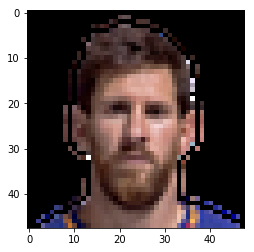

In [169]:
plt.imshow(cv2.cvtColor(np.multiply(img, np.expand_dims(binary,2)), cv2.COLOR_BGR2RGB))

Well, that's what I call fast and simple. Still we need to determine a good threshold to binarize our alpha channel since we are still getting some noiy pixels here. Let's check how do the pixel intensities of a few image alphas distribute:

In [157]:
tmp_file = 'Data/tmp.png'
number_of_images = 50
alphas_list = []

for url in data.Photo[:number_of_images]:
    download_image_from_url(url, tmp_file)
    tmp_img = cv2.imread(tmp_file, cv2.IMREAD_UNCHANGED)
    alpha_ = tmp_img[...,3]
    alphas_list.append(np.hstack(alpha_))

# Create flat array with all alphas
flat_alphas = np.concatenate(alphas_list)

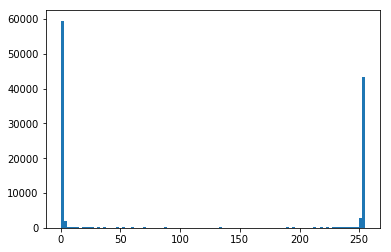

In [158]:
plt.hist(flat_alphas, bins=100)
plt.show()

Mmm... Difficult to see something different from 0 or 255 bins. Let's filter these values and check again!


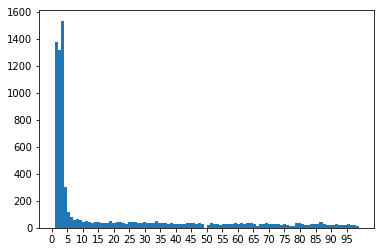

In [173]:
filtered = flat_alphas[((flat_alphas>0) & (flat_alphas<100))]
plt.hist(filtered, bins=100)
plt.xticks(np.arange(0, 100, step=5))
plt.show()

We can observe that there are none images with pixels values of 48,49... That might point to something related with the smoothing operation that was applied to our dataset. Let's set 50 as our threshold.


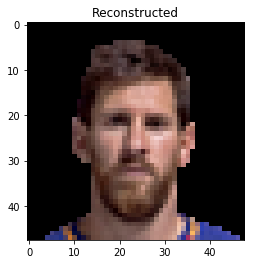

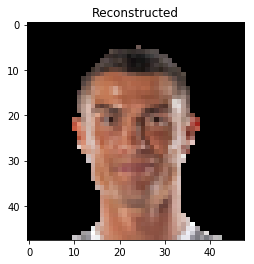

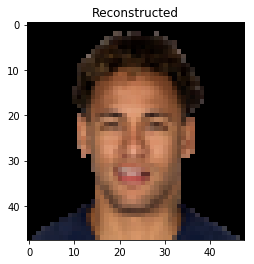

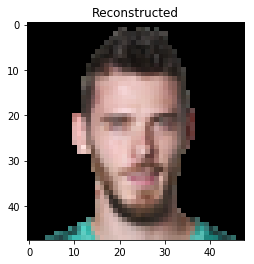

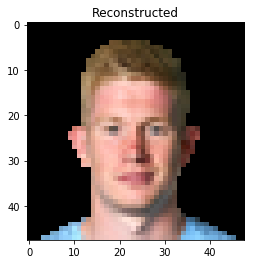

In [194]:
threshold = 50
for url in data.Photo[:5]:
    download_image_from_url(url, tmp_file)
    tmp_img = cv2.imread(tmp_file, cv2.IMREAD_UNCHANGED)
    binary = (tmp_img[:,:,3]>threshold)
    plt.imshow(cv2.cvtColor(np.multiply(tmp_img, np.expand_dims(binary,2)), cv2.COLOR_BGR2RGB))
    plt.title('Reconstructed')
    plt.show()

## Eureka!

We got it, this seems a good starting point!

<Figure size 1080x1080 with 0 Axes>

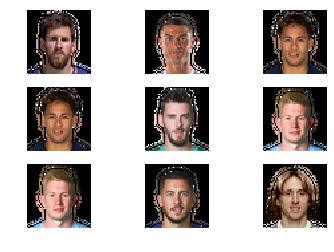

In [189]:
plt.figure(figsize=(15,15))
a, axarr = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        download_image_from_url(data.Photo[2*i+j], tmp_file)
        tmp_img = cv2.imread(tmp_file, cv2.IMREAD_UNCHANGED)
        axarr[i, j].imshow(cv2.cvtColor(tmp_img, cv2.COLOR_BGR2RGB))
        axarr[i, j].axis('off')
plt.savefig('Data/show.png')